<small><i>This notebook was put together by [Anderson Banihirwe](https://andersy005.github.io/) as part of [2017 CISL/SIParCS Research Project](https://ncar.github.io/PySpark4Climate/): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>

# Median

- A commonly used robust and resistant measure of central tendency.
- Defined as the middle value when observations are ordered from smallest to largest.
- Divides the dataset into two parts of equal size, with 50% of the values below the median and 50% of the values above the median.
- Also known as the 50th percentile.
- Insensitive to extreme values.

# Example:

- Calculate the spatial median of temperature data over  North America for the period 2006-2010.
- The dataset can be found on [NCAR's Glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces): 

  - ```/glade/p/CMIP/CMIP5/output1/NOAA-GFDL/GFDL-ESM2M/rcp85/mon/atmos/Amon/r1i1p1/v20111228/ta/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc```

# Step 1: Load Dataset in a Spark dataframe

In [1]:
from pyspark4climate import read
from pyspark4climate.functions import shift_lon_udf
from pyspark.sql import SparkSession
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 15)
%matplotlib inline
import matplotlib.pyplot as plt
jet=plt.get_cmap('coolwarm')  # Used for multiple scatter plots

In [2]:
spark = SparkSession.builder.appName("median").getOrCreate()
sc = spark.sparkContext

In [3]:
!ncdump -h ../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc

netcdf ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012 {
dimensions:
	plev = 17 ;
	time = UNLIMITED ; // (60 currently)
	lat = 90 ;
	lon = 144 ;
	bnds = 2 ;
variables:
	double plev(plev) ;
		plev:units = "Pa" ;
		plev:long_name = "pressure" ;
		plev:axis = "Z" ;
		plev:positive = "down" ;
		plev:standard_name = "air_pressure" ;
	double average_DT(time) ;
		average_DT:long_name = "Length of average period" ;
		average_DT:units = "days" ;
	double average_T1(time) ;
		average_T1:long_name = "Start time for average period" ;
		average_T1:units = "days since 2006-01-01 00:00:00" ;
	double average_T2(time) ;
		average_T2:long_name = "End time for average period" ;
		average_T2:units = "days since 2006-01-01 00:00:00" ;
	double lat(lat) ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
		lat:bounds = "lat_bnds" ;
	double lon(lon) ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:standard_name = "longitude"

In [4]:
filename='../data/ta_Amon_GFDL-ESM2M_rcp85_r1i1p1_200601-201012.nc'
var = 'ta'

In [5]:
data = read.DataFrame(sc, (filename, var), mode='single')

Pyspark4climate DataFrame class returns an object.
In order to access spark's dataframe we need to do the following:

In [6]:
type(data)

pyspark4climate.read.DataFrame

In [7]:
data_df = data.df
type(data_df)

pyspark.sql.dataframe.DataFrame

In [8]:
data_df.show()

+-------------------+--------+------------------+------------------+----+
|               time|    plev|               lat|               lon|  ta|
+-------------------+--------+------------------+------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            256.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            258.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            261.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            263.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            266.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            268.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            271.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|273.74999999999994|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            276.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            278.75|null|
|2006-01-16 12:00:00|100000.0|-71.7977

In [9]:
# Print the schema of data_df dataframe
data_df.printSchema()

root
 |-- time: string (nullable = true)
 |-- plev: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- ta: double (nullable = true)



# Step 2: Shift longitudes on grid so that they are in range [-180 -> 180]

To achieve this we will use ```pyspark4climate``` builtin function ```shift_grid_udf()```

In [10]:
# Shift grid and Drop the lon column
data_df = data_df.withColumn("shifted_lon", shift_lon_udf(data_df["lon"])).cache()
data_df = data_df.selectExpr("time", "plev", "lat", "shifted_lon as lon", "ta")

In [11]:
data_df.show()

+-------------------+--------+------------------+-------------------+----+
|               time|    plev|               lat|                lon|  ta|
+-------------------+--------+------------------+-------------------+----+
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -103.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|            -101.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -98.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -96.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -93.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -91.25|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -88.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527| -86.25000000000006|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -83.75|null|
|2006-01-16 12:00:00|100000.0|-85.95505617977527|             -81.25|null|
|2006-01-16 12:00:00|1000

# Step 3: Select Temporal and Spatial Domains

Select North-America: Region with only values 60W to 130W, 20N to 70N

In [12]:
import pyspark.sql.functions as F

In [13]:
df = data_df.filter((data_df["lon"] <= -60) & (data_df["lon"] >=-130) &\
                 (data_df["lat"] >=20) & (data_df["lat"] <=70))\
                 .orderBy(F.col('time'), F.col('lat'), F.col('lon'))
df.show()

+-------------------+--------+------------------+-------------------+------------------+
|               time|    plev|               lat|                lon|                ta|
+-------------------+--------+------------------+-------------------+------------------+
|2006-01-16 12:00:00|100000.0|21.235955056179776|-128.74999999999997|290.64520263671875|
|2006-01-16 12:00:00| 70000.0|21.235955056179776|-128.74999999999997|278.41375732421875|
|2006-01-16 12:00:00| 92500.0|21.235955056179776|-128.74999999999997| 284.8731384277344|
|2006-01-16 12:00:00| 40000.0|21.235955056179776|-128.74999999999997|250.10055541992188|
|2006-01-16 12:00:00| 60000.0|21.235955056179776|-128.74999999999997|  271.363037109375|
|2006-01-16 12:00:00| 85000.0|21.235955056179776|-128.74999999999997|  284.496337890625|
|2006-01-16 12:00:00| 10000.0|21.235955056179776|-128.74999999999997|200.11734008789062|
|2006-01-16 12:00:00|  3000.0|21.235955056179776|-128.74999999999997|218.32974243164062|
|2006-01-16 12:00:00|

In [15]:
df.cache()

DataFrame[time: string, plev: double, lat: double, lon: double, ta: double]

# Step 4: Calculate Spatial Median
- This operation computes the spatial median of the data. The median longitude and median latitude values are located for each time step.

- To compute the median using Spark, we will need to use **Spark Window function**. At its core, a window function calculates a return value for every input row of a table based on a group of rows, called the Frame. Every input row can have a unique frame associated with it. This characteristic of window functions makes them more powerful than other functions and allows users to express various data processing tasks that are hard (if not impossible) to be expressed without window functions in a concise way. You can get more details at this link: (https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html)

- As a rule of thumb window definitions should always contain ```PARTITION BY``` clause otherwise Spark will move all data to a single partition. ```ORDER BY``` is required for some functions, while in different cases (typically aggregates) may be optional.

- There are also two optional which can be used to define window span ```ROWS BETWEEN``` and ```RANGE BETWEEN```.

In [16]:
from pyspark.sql.window import Window

Once a function is marked as a window function, the next key step is to define the Window Specification associated with this function. A window specification defines which rows are included in the frame associated with a given input row. A window specification includes three parts:

- Partitioning Specification: controls which rows will be in the same partition with the given row. In our case, we will make sure all rows having the same value for the time column are collected to the same machine before ordering and calculating the frame.  If no partitioning specification is given, then all data must be collected to a single machine.
- Ordering Specification: controls the way that rows in a partition are ordered, determining the position of the given row in its partition.
- Frame Specification: states which rows will be included in the frame for the current input row, based on their relative position to the current row. We don't need this in our case.

In [17]:
windowSpec = Window.partitionBy(df['time']).orderBy(df['ta'])

- ```percent_rank()``` returns the relative rank (i.e. percentile) of rows within a window partition.

In [18]:
df = df.select("time", "ta", F.percent_rank().over(windowSpec).alias("percent_rank"),
              F.row_number().over(windowSpec).alias("row_number"))
df.show()

+-------------------+----+------------+----------+
|               time|  ta|percent_rank|row_number|
+-------------------+----+------------+----------+
|2008-03-15 12:00:00|null|         0.0|         1|
|2008-03-15 12:00:00|null|         0.0|         2|
|2008-03-15 12:00:00|null|         0.0|         3|
|2008-03-15 12:00:00|null|         0.0|         4|
|2008-03-15 12:00:00|null|         0.0|         5|
|2008-03-15 12:00:00|null|         0.0|         6|
|2008-03-15 12:00:00|null|         0.0|         7|
|2008-03-15 12:00:00|null|         0.0|         8|
|2008-03-15 12:00:00|null|         0.0|         9|
|2008-03-15 12:00:00|null|         0.0|        10|
|2008-03-15 12:00:00|null|         0.0|        11|
|2008-03-15 12:00:00|null|         0.0|        12|
|2008-03-15 12:00:00|null|         0.0|        13|
|2008-03-15 12:00:00|null|         0.0|        14|
|2008-03-15 12:00:00|null|         0.0|        15|
|2008-03-15 12:00:00|null|         0.0|        16|
|2008-03-15 12:00:00|null|     

In [19]:
df.describe('row_number').show()

+-------+------------------+
|summary|        row_number|
+-------+------------------+
|  count|            714000|
|   mean|            5950.5|
| stddev|3435.2364951777067|
|    min|                 1|
|    max|             11900|
+-------+------------------+



In [20]:
# For each time step there are 11900 rows
# Because our ta values are now order in ascending order, the median will be located at
# row_count / 2 + 1 if row_count is even or at row_count + 1 / 2 if row_count is odd.
row_count = 11900
row_num = (11900 / 2) + 1

In [21]:
spatial_median = df.select(df.time, df.ta, df.percent_rank, 
                           df.row_number.between(row_num, row_num).alias('median_loc')).cache()

In [24]:
median = spatial_median.filter(spatial_median.median_loc == True).orderBy("time")
median.show()

+-------------------+------------------+------------------+----------+
|               time|                ta|      percent_rank|median_loc|
+-------------------+------------------+------------------+----------+
|2006-01-16 12:00:00|220.62489318847656|0.5000420203378435|      true|
|2006-02-15 00:00:00|222.18905639648438|0.5000420203378435|      true|
|2006-03-16 12:00:00|223.45294189453125|0.5000420203378435|      true|
|2006-04-16 00:00:00|223.97760009765625|0.5000420203378435|      true|
|2006-05-16 12:00:00|227.18658447265625|0.5000420203378435|      true|
|2006-06-16 00:00:00|228.31100463867188|0.5000420203378435|      true|
|2006-07-16 12:00:00| 229.8331298828125|0.5000420203378435|      true|
|2006-08-16 12:00:00|229.47373962402344|0.5000420203378435|      true|
|2006-09-16 00:00:00|227.04518127441406|0.5000420203378435|      true|
|2006-10-16 12:00:00| 223.9647674560547|0.5000420203378435|      true|
|2006-11-16 00:00:00|   222.23876953125|0.5000420203378435|      true|
|2006-

# Step 5: Plot the spatial median data

In [34]:
# convert the spark dataframe to pandas dataframe for visualization
df = median.toPandas()
df.describe()

,ta,percent_rank
count,60.000000,60.000000
mean,224.984187,0.500042
std,3.163610,0.000000
min,220.095398,0.500042
25%,222.240623,0.500042
50%,223.997536,0.500042
75%,227.544090,0.500042
max,230.117661,0.500042


In [35]:
df.head()

,time,ta,percent_rank,median_loc
0,2006-01-16 12:00:00,220.624893,0.500042,True
1,2006-02-15 00:00:00,222.189056,0.500042,True
2,2006-03-16 12:00:00,223.452942,0.500042,True
3,2006-04-16 00:00:00,223.977600,0.500042,True
4,2006-05-16 12:00:00,227.186584,0.500042,True


In [36]:
df = df.set_index('time').drop(['percent_rank', 'median_loc'], axis=1)
df.head()

,ta
time,
2006-01-16 12:00:00,220.624893
2006-02-15 00:00:00,222.189056
2006-03-16 12:00:00,223.452942
2006-04-16 00:00:00,223.977600
2006-05-16 12:00:00,227.186584


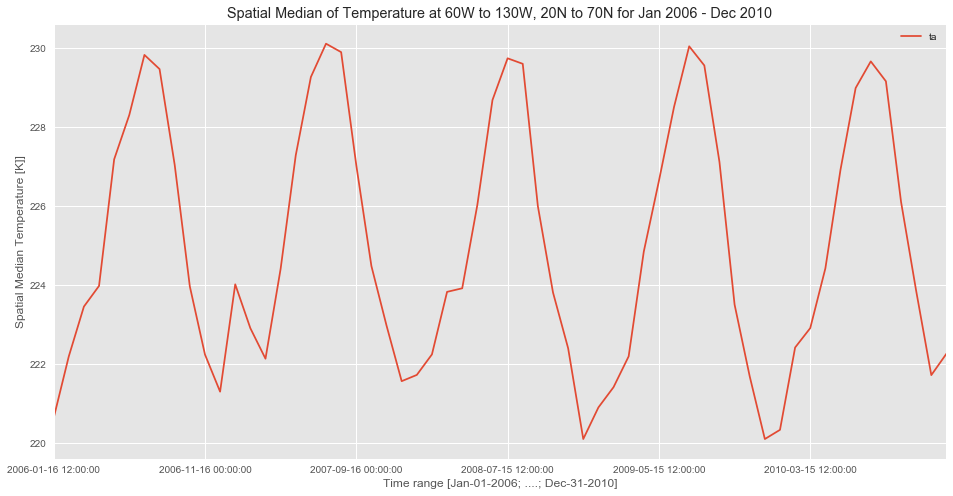

In [38]:
ax = df['ta'].plot(legend=True, figsize=(16, 8))
ax.set_xlabel("Time range [Jan-01-2006; ....; Dec-31-2010]")
ax.set_ylabel("Spatial Median Temperature [K]]")
ax.set_title("Spatial Median of Temperature at 60W to 130W, 20N to 70N for Jan 2006 - Dec 2010")
plt.show()

The spatial median time series looks similar to the spatial average time series from the previous example (https://github.com/NCAR/CMIPscripts/blob/master/pyspark/Statistical-Techniques/01-Measures-of-Central-Tendency/01-mean.ipynb). Yet, even though the two images look similar, they are not identical. In a non-symmetrical dataset such as this, the median is different from the mean.